In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import seaborn as sns



import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot


from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
df=pd.read_csv('/content/climate test.csv')
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [ ]:
df.isnull().sum()

,0
date,0
meantemp,0
humidity,0
wind_speed,0
meanpressure,0


In [ ]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,114.000000,114.000000,114.000000,114.000000
mean,21.713079,56.258362,8.143924,1004.035090
std,6.360072,19.068083,3.588049,89.474692
min,11.000000,17.750000,1.387500,59.000000
25%,16.437198,39.625000,5.563542,1007.437500
50%,19.875000,57.750000,8.069444,1012.739316
75%,27.705357,71.902778,10.068750,1016.739583
max,34.500000,95.833333,19.314286,1022.809524


In [ ]:
df.dtypes

,0
date,object
meantemp,float64
humidity,float64
wind_speed,float64
meanpressure,float64


In [ ]:
float_columns=df.select_dtypes(include=['float64']).columns
print("Float columns:", float_columns) # Use the correct variable name 'float_columns'

Float columns: Index(['meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('date', axis=1)
y = df['meantemp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

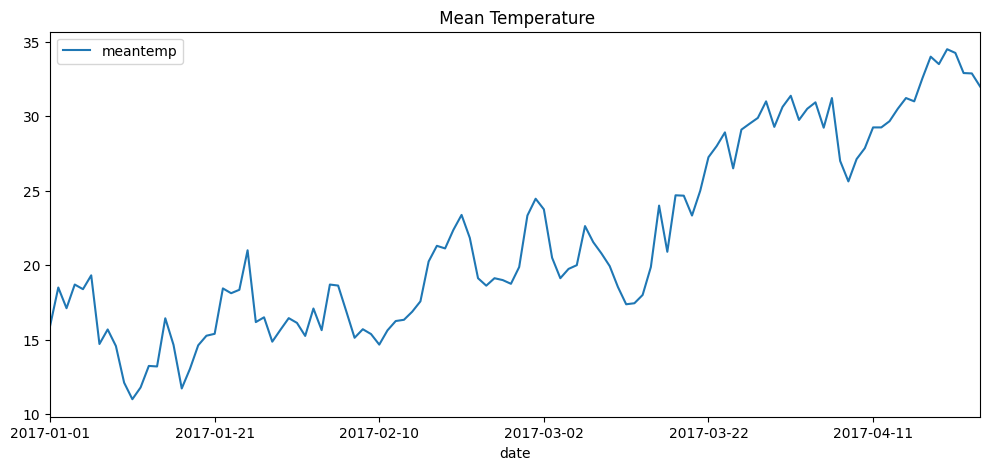

In [ ]:
df.plot(figsize=(12,5),title=' Mean Temperature', x='date', y='meantemp').autoscale(axis='x',tight=True)

Text(0, 0.5, 'meantemp')

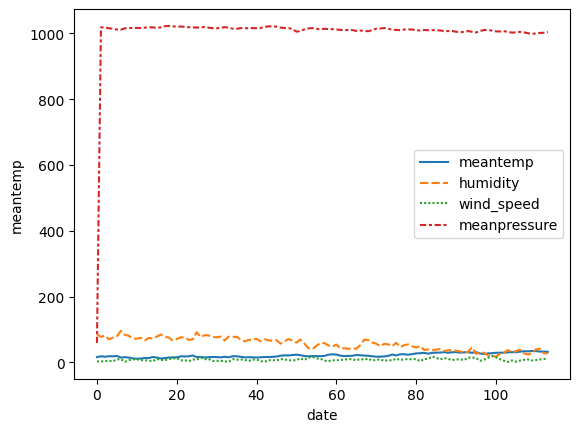

In [ ]:
sns.lineplot(df.drop('date',axis=1))
plt.xlabel('date')
plt.ylabel('meantemp')

Text(0.5, 1.0, 'Average pressure')

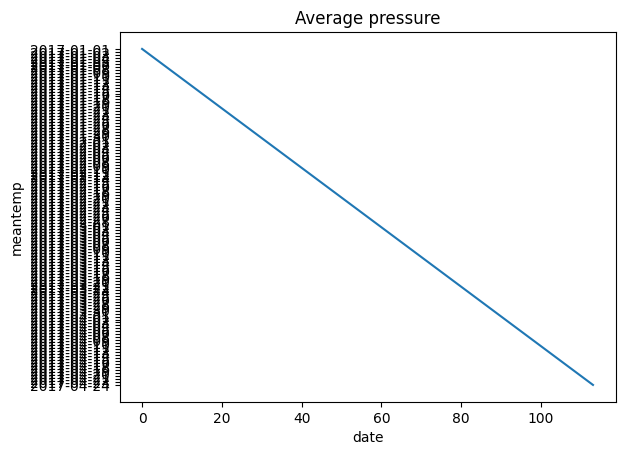

In [ ]:
sns.lineplot(df.date)
plt.xlabel('date')
plt.ylabel('meantemp')
plt.title('Average pressure')

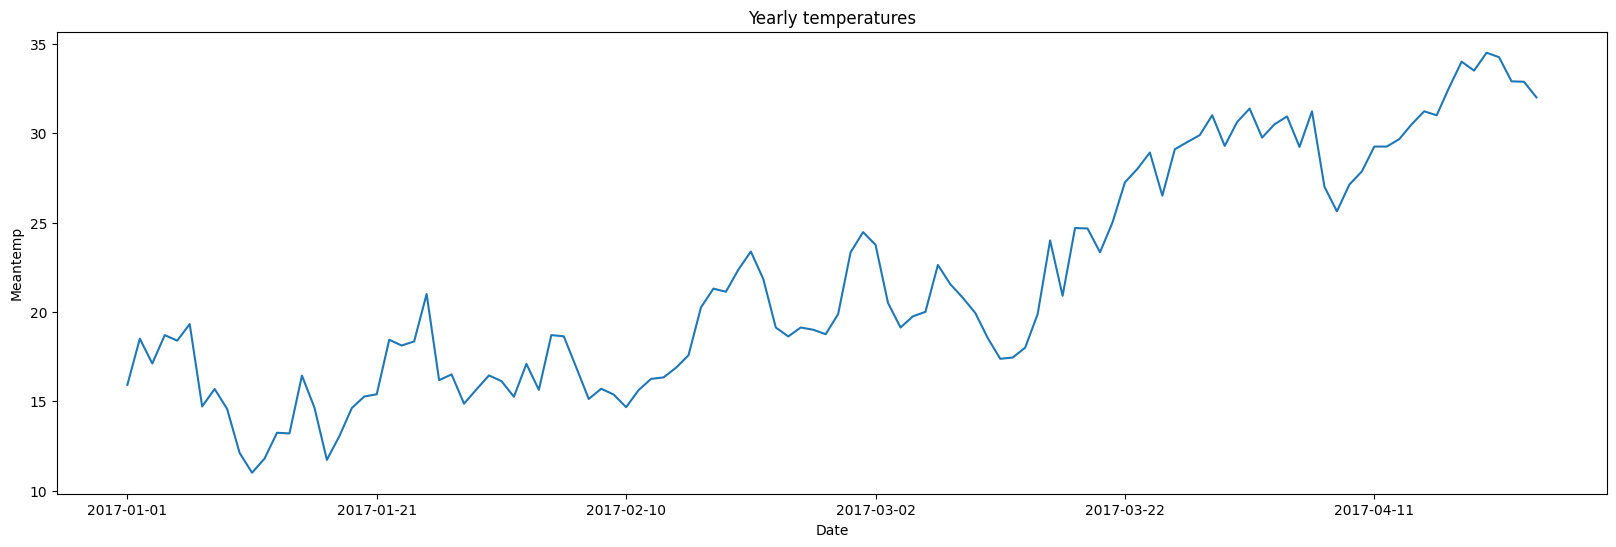

In [ ]:
pivot = pd.pivot_table(df, values='meantemp', index='date', aggfunc='mean')
pivot.plot(figsize=(20,6))
plt.title('Yearly temperatures')
plt.xlabel('Date')
plt.ylabel('Meantemp')
plt.legend().remove()
plt.show()

In [ ]:
train = df[:-60].copy()
val = df[-60:-12].copy()
test = df[-12:].copy()

In [ ]:
baseline = val['meantemp'].shift()
baseline.dropna(inplace=True)
baseline.head()

,meantemp
55,19.125000
56,19.000000
57,18.750000
58,19.875000
59,23.333333


In [ ]:
def check_stationarity(y, lags_plots=48, figsize=(22,8)):
    "Use Series as parameter"

    # Handle missing or infinite data
    y = pd.Series(y).dropna()  # Drop missing values
    y = y.replace([np.inf, -np.inf], np.nan).dropna()  # Replace infinite values with NaN, then drop NaNs

    # Creating plots of the DF
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title(' Temperature Variation')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
    ax4.set_title('Distribution Chart')

    plt.tight_layout()

    print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)

    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)

    print(adftest)

    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe serie seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe serie isn't stationary")

In [ ]:
def check_stationarity(y, lags_plots=None, figsize=(22,8)):
    "Use Series as parameter"

    # Handle missing or infinite data
    y = pd.Series(y).dropna()  # Drop missing values
    y = y.replace([np.inf, -np.inf], np.nan).dropna()  # Replace infinite values with NaN, then drop NaNs

    # Determine appropriate number of lags if not provided
    if lags_plots is None:
        lags_plots = min(10 * np.log10(len(y)), len(y) // 2 - 1)

    # Creating plots of the DF
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title(' Temperature Variation')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3); # Use calculated lags_plots
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
    ax4.set_title('Distribution Chart')

    plt.tight_layout()

    print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)

    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)

    print(adftest)

    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe serie seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe serie isn't stationary")

Results of Dickey-Fuller Test:
Test Statistic                 -2.3554
p-value                         0.1547
Lags Used                       0.0000
Number of Observations Used    53.0000
Critical Value (1%)            -3.5602
Critical Value (5%)            -2.9179
Critical Value (10%)           -2.5968
dtype: float64

The Test Statistics is higher than the Critical Value of 5%.
The serie isn't stationary


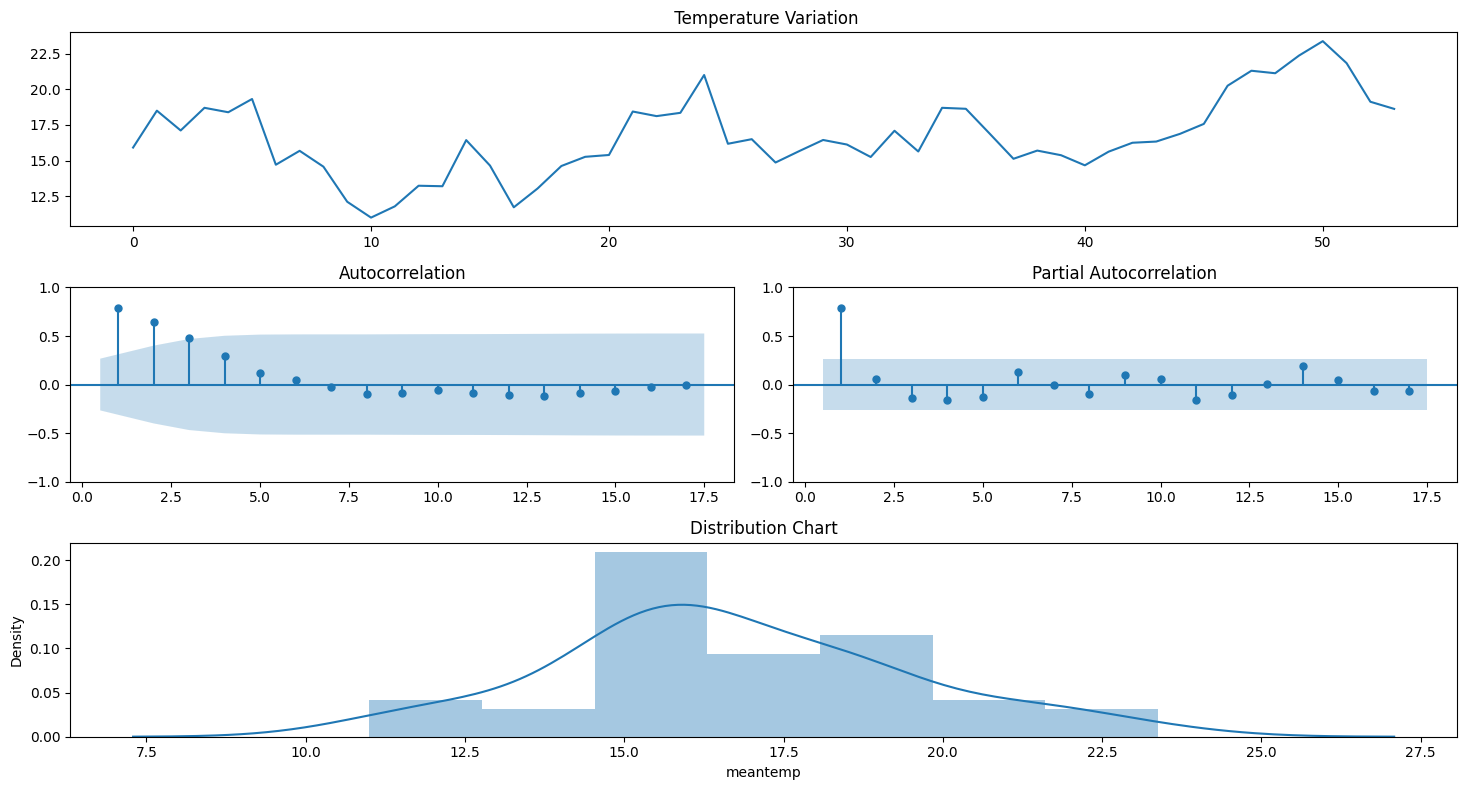

In [ ]:
# The first approach is to check the series without any transformation
check_stationarity(train['meantemp'])

In [ ]:
def adf_test(series):
    result = adfuller(series)
    p_value = result[1]
    if p_value < 0.05:
        print("The series is stationary (p < 0.05)")
    else:
        print("The series is non-stationary (p >= 0.05)")
    return p_value

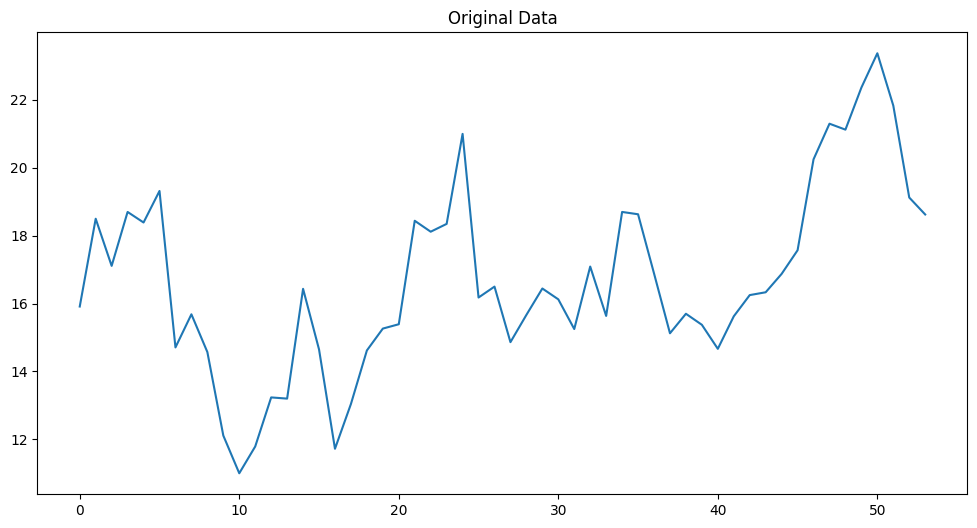

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train['meantemp'], label='Original Data')
plt.title("Original Data")
plt.show()

In [ ]:
print("ADF Test on Original Data:")
adf_test(train['meantemp'])

ADF Test on Original Data:
The series is non-stationary (p >= 0.05)


0.15472878632479997

In [ ]:
data = train['meantemp']
data_diff = data.diff().dropna()
print("\nADF Test on Differenced Data:")
adf_test(data_diff)


ADF Test on Differenced Data:
The series is stationary (p < 0.05)


2.130807242061416e-13

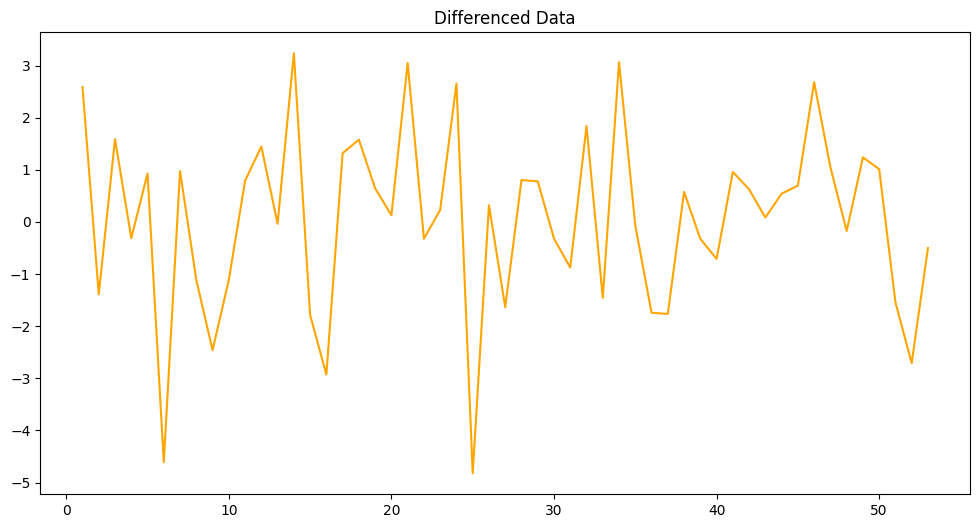

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(data_diff, label='Differenced Data', color='orange')
plt.title("Differenced Data")
plt.show()


In [ ]:
data_log = np.log(data[data > 0])
data_log_diff = data_log.diff().dropna()
print("\nADF Test on Log Differenced Data:")
adf_test(data_log_diff)


ADF Test on Log Differenced Data:
The series is stationary (p < 0.05)


7.544995523462617e-13

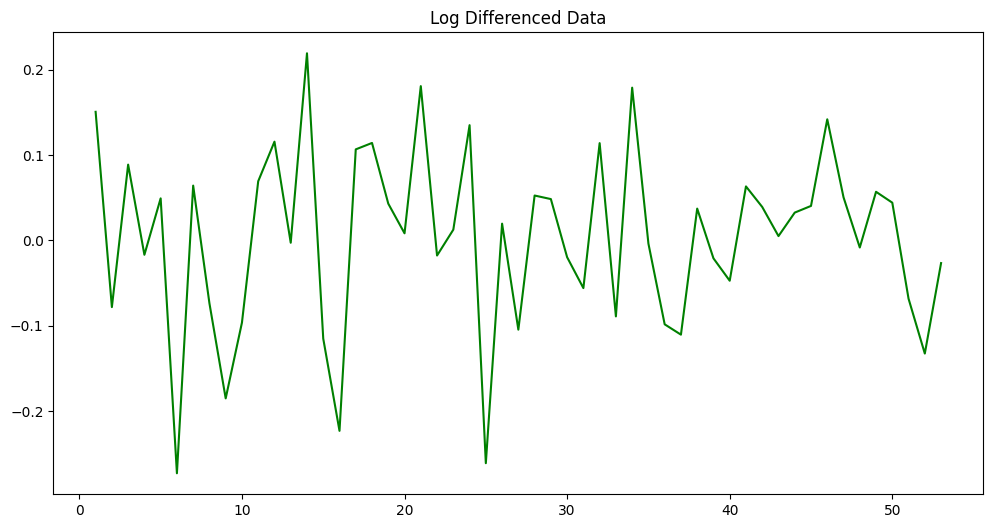

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(data_log_diff, label='Log Differenced Data', color='green')
plt.title("Log Differenced Data")
plt.show()


In [ ]:
!pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA
# Assuming 'train' is the DataFrame containing 'AverageTemperature'
model = ARIMA(train['meantemp'], order=(5, 1, 0))  # Reference the column within the DataFrame
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                   54
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -102.632
Date:                Sun, 27 Oct 2024   AIC                            217.264
Time:                        15:48:13   BIC                            229.086
Sample:                             0   HQIC                           221.810
                                 - 54                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1541      0.179     -0.861      0.389      -0.505       0.197
ar.L2          0.0229      0.168      0.136      0.892      -0.307       0.353
ar.L3          0.0149      0.135      0.110      0.9

Text(0.5, 1.0, 'Model predictions based on linear regression')

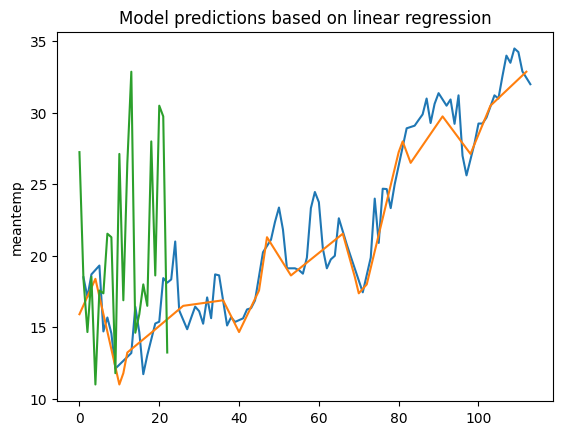

In [ ]:
sns.lineplot(y_train)
sns.lineplot(y_test)
sns.lineplot(predictions)
plt.title('Model predictions based on linear regression')

In [ ]:
forecast_steps = 12  # Forecast for the next 12 months
forecast = model_fit.get_forecast(steps=forecast_steps)


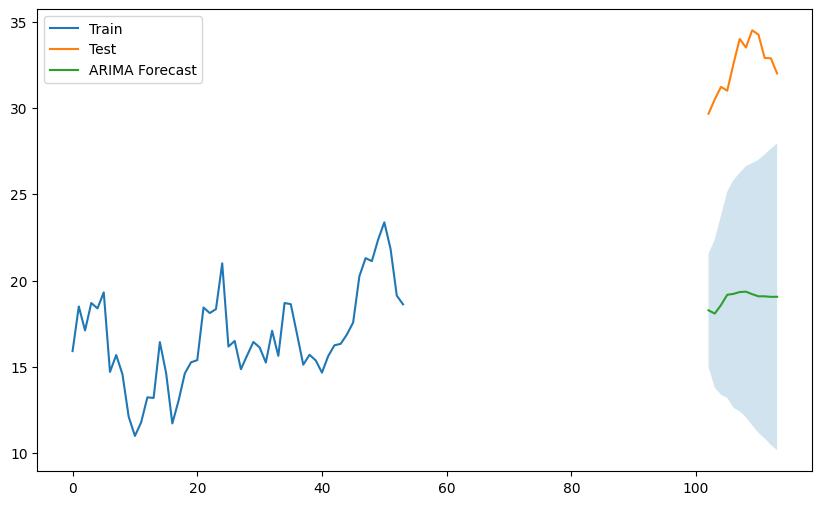

In [ ]:
# Plot the results
plt.figure(figsize=(10,6))
plt.plot(train['meantemp'], label='Train')  # Plot only the numerical column
plt.plot(test['meantemp'], label='Test')  # Plot only the numerical column

# Extract the forecasted values and confidence intervals
arima_forecast = forecast.predicted_mean
arima_conf_int = forecast.conf_int()

# Plot the forecast
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.fill_between(test.index, arima_conf_int.iloc[:, 0], arima_conf_int.iloc[:, 1], alpha=0.2)  # Add confidence interval

plt.legend()
plt.show()

In [ ]:
def measure_rmse(y_true, y_pred):
    # Ensure both y_true and y_pred are numeric by converting them to floats.
    y_true = y_true.astype(float)
    y_pred = y_pred.astype(float)
    return sqrt(mean_squared_error(y_true,y_pred))

# Using the function with the baseline values, selecting 'AverageTemperature' column
rmse_base = measure_rmse(val.iloc[1:,1],baseline)  # Use column index 1 for 'AverageTemperature'
print(f'The RMSE of the baseline that we will try to diminish is {round(rmse_base,4)} celsius degrees')

The RMSE of the baseline that we will try to diminish is 1.7904 celsius degrees


In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'train' is the DataFrame containing 'AverageTemperature'
model = ARIMA(train['meantemp'], order=(5, 1, 0))  # Reference the column within the DataFrame
model_fit = model.fit()

# Generate predictions
# Replace with the actual start and end index or dates for your test set
start_index = 0
end_index = len(test) - 1
predictions = model_fit.predict(start=start_index, end=end_index)

# 'predictions' now holds the model predictions and 'test' is your test DataFrame
# with a column named 'AverageTemperature'
print('MEA:',mean_absolute_error(test['meantemp'], predictions))
print('MSE:',mean_squared_error(test['meantemp'], predictions))
print('RMSE:',np.sqrt(mean_squared_error(test['meantemp'], predictions)))

MEA: 17.661334446864103
MSE: 331.2109960088589
RMSE: 18.19920316961319


In [ ]:
from sklearn.ensemble import BaggingRegressor  # Import BaggingRegressor instead
from sklearn.tree import DecisionTreeRegressor # Import DecisionTreeRegressor instead

# Change 'base_estimator' to 'estimator'
bagging_regressor = BaggingRegressor(
    estimator=DecisionTreeRegressor(),  # Updated parameter name and estimator
    n_estimators=50,
    max_samples=0.8,
    max_features=0.8,
    random_state=42,
    n_jobs=-1
)
bagging_regressor.fit(X_train, y_train)
y_pred = bagging_regressor.predict(X_test)

# Use a regression metric like mean squared error or R-squared for evaluation
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 1.9667990457510536
R-squared: 0.949491380773237


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression # Changed model to LinearRegression
from sklearn.metrics import mean_squared_error # Changed metric to mean_squared_error


X = df.drop('date', axis=1)
y = df['meantemp']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple Linear Regression model # Changed model to LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred) # Changed metric to mean_squared_error
print(f"Model Mean Squared Error: {mse:.2f}")

Model Mean Squared Error: 0.00


In [ ]:
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

In [ ]:
with open("model.pkl", "rb") as f:
    model = pickle.load(f)

In [ ]:
import pickle
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
# Use LinearRegression for continuous target variables
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error # Changed to appropriate metric for regression

# Load dataset
X = df.drop('date', axis=1)
y = df['meantemp']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Save the trained model to a Pickle file
with open('trained_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Load the trained model from the Pickle file
with open('trained_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Verify the type of the loaded model
print(type(loaded_model))  # Should be <class 'sklearn.linear_model._linear.LinearRegression'>

# Use the loaded model for predictions
predictions = loaded_model.predict(X_test)

# Print predictions
print(predictions)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, predictions)
print(f"Model Mean Squared Error: {mse:.2f}")

<class 'sklearn.linear_model._base.LinearRegression'>
[27.25       18.38888889 14.66666667 18.53333333 11.         17.57142857
 17.375      21.54545455 21.3        11.78947368 27.125      16.88888889
 26.5        32.875      14.61904762 15.91304348 18.         16.5
 28.         18.625      30.5        29.75       13.23529412]
Model Mean Squared Error: 0.00
